AI Programming - SW Lee

# Lab 02: Simple Deep Neural Network
## Exercise: Predicting MNIST Digits

### Prepare Mini-MNIST Dataset from Scikit-Learn
http://yann.lecun.com/exdb/mnist/

In [136]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [137]:
digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

Sigmoid function can be defined as:

$$ \text{sigmoid}(x) = {1 \over {1 + e^{-x}}} = {e^{x} \over {1 + e^{x}}} $$

Sigmoid function takes numbers between $[-\infty, \infty]$ and gives back numbers between $[0, 1]$.<br>
However, the corresponding numpy implementation warns overflow for large negative inputs.<br>
The function below is the implementation of numerically stable sigmoid. Complete the code **without using `if` statement**.

In [138]:
def mySigmoid(x):
    ### START CODE HERE ###

    positive = (x >= 0) # Create a boolean array indicating which elements in x are positive 
    x_p = x[positive]   # Extract the positive values from x
    x_n = x[~positive]  # Extract the negative values from x
    x[positive] = 1 / (1 + np.exp(-x_p))            # Apply the sigmoid function to the positive values
    x[~positive] = np.exp(x_n) / (1 + np.exp(x_n))  # Apply the sigmoid function to the negative values

    ### END CODE HERE ###
    return x

In [139]:
mySigmoid(np.array([0.0, 1000.0, -1000.0]))

array([0.5, 1. , 0. ])

Softmax function can be defined as:

$$ \text{softmax}(x_i) = {e^{x_i} \over {\sum_{k=1}^n e^{x_k}}} $$

Softmax function also takes numbers between $[-\infty, \infty]$ and gives back numbers between $[0, 1]$.<br>
Therefore, this function has the same overflow problem for large positive inputs.<br>
The function below is the implementation of numerically stable softmax.<br>
You can make the softmax stable by multiplying $e^{-M}$ to both numerator and denominator. <br>
Complete the code **without using `if` statement**.

In [140]:
# define softmax. Assume (b, s)
def mySoftmax(x):
    ### START CODE HERE ###
    
    x = x - np.max(x, axis = -1, keepdims = True)        # Subtract the max value from each row for make x sufficiently small
    x = np.exp(x)                                        # execute exponential function
    x = x / np.sum(x, axis = -1, keepdims = True)        # calculate softmax

    ### END CODE HERE ###
    return x

In [141]:
mySoftmax(np.array([0.0, 1000.0, -1000.0]))

array([0., 1., 0.])

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


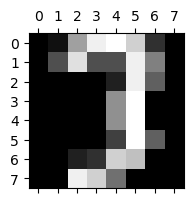

The number is 3


In [142]:
# Print the shape of the digits DataFrame and the training data
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
# Print the first sample from the original training data
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0]) # Randomly select an index from the training data
dimage = X_train_org[idx].reshape((8,8))  # Reshape the selected sample
# Plot the image
plt.figure(figsize=(2, 2))
plt.gray()
plt.matshow(dimage, fignum=1)
plt.show()
print('The number is', y_train_num[idx])

### Simple DNN for Digit Classification

Define Model Class

In [143]:
class myDenseLayer:
    def __init__(self, n_out, n_in):
        # Initialize the weights and biases
        self.wegt = np.empty((n_out, n_in))
        self.bias = np.zeros((n_out))
        self.saved_x = None     # store x to use while backpropagation

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        self.saved_x = x                                          # Save x for use in backpropagation
        x_lin = (np.matmul(self.wegt, x.T).T) + self.bias         # Linear Prediction
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        # Check if input during forward pass matches the one during backpropagation
        assert np.array_equal(self.saved_x, x_in), print('x_in does not equal to input X.')
        ### START CODE HERE ###
        
        dw = np.matmul(x.T, x_in)         # Gradients for weights
        db = np.sum(x, axis = 0)          # Gradients for biases
        wdJdz = np.matmul(x, self.wegt)   # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz

In [144]:
np.random.seed(0)

tmp = myDenseLayer(3,5)
tmp.wegt = np.random.randn(3,5)
tmp.bias = np.random.randn(3)

print(tmp.forward(np.random.randn(2,5,3)))

[[[ 3.23890168  3.05091188 -3.32627831]
  [ 0.388114    3.36724875  1.06158492]
  [ 3.10267869  1.87570497 -1.8326582 ]]

 [[-7.60581826  2.36703751 -1.16423539]
  [ 3.48035012  2.41940644 -0.13917734]
  [ 1.20541315  2.07585619 -1.5435161 ]]]


**Expected Outputs**

```
[[[ 3.23890168  3.05091188 -3.32627831]
  [ 0.388114    3.36724875  1.06158492]
  [ 3.10267869  1.87570497 -1.8326582 ]]

 [[-7.60581826  2.36703751 -1.16423539]
  [ 3.48035012  2.41940644 -0.13917734]
  [ 1.20541315  2.07585619 -1.5435161 ]]]
```

Define Backpropagation of Activation Functions

In [145]:
def dJdz_sigmoid(wdJdz_upper, az): # Backpropagation through the sigmoid activation function
    ### START CODE HERE ###

    dJdz = wdJdz_upper * (az * (1 - az))  # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):       # Backpropagation through the softmax activation function
    ### START CODE HERE ###
    
    dJdz =  y_hat - y                     # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

In [146]:
np.random.seed(0)

print(dJdz_sigmoid(np.random.randn(3),np.random.randn(3)))
print(dJdz_softmax(np.random.randn(3),np.random.randn(3)))

[-4.90531647 -0.64834065 -1.89126428]
[ 0.53948992 -0.29540078 -1.55749236]


**Expected Outputs**

```
[-4.90531647 -0.64834065 -1.89126428]
[ 0.53948992 -0.29540078 -1.55749236]
```

Define Training Functions<br>

In [147]:
def my_forward(l1, l2, l3, X_in): # Forward propagation through three layers
    ### START CODE HERE ###

    a_1 = mySigmoid(l1.forward(X_in))                 # first stage forward(sigmoid)
    a_2 = mySigmoid(l2.forward(a_1))                  # second stage forward(sigmoid)
    a_3 = mySoftmax(l3.forward(a_2))                  # third stage forward(softmax)

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, a_1, a_2, a_3, X_in, y_true): # Backward propagation through three layers
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)     # go through 3rd stage backward(softmax)
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2), a_1)    # go through 2nd stage backward(sigmoid)
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2, a_1), X_in)   # go through 1st stage backward(sigmoid)

    ### END CODE HERE ###

    # Return gradients for all layers
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    
    return d_1, d_2, d_3

def my_loss(l1, l2, l3, X_in, y_true): # Calculate the loss
    ### START CODE HERE ###

    a_1,a_2,a_3 = my_forward(l1, l2, l3, X_in)                   # Forward pass to get the predictions
    loss = -(np.sum(y_true * np.log(a_3))) / X_in.shape[0]       # calculate cross-entropy loss

    ### END CODE HERE ###
    return loss
    
def my_predict(l1, l2, l3, X_in):     # Make predictions
    ### START CODE HERE ###
    
    a_1,a_2,a_3 = my_forward(l1, l2, l3, X_in)       # Forward pass to get the softmax probabilities
    pred = np.argmax(a_3, axis=1)                    # make prediction

    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [148]:
# Define the number of inputs, hidden units, and output classes
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

# Initialize three layers of the neural network
l1 = myDenseLayer(n_hidden1, n_inputs)
l2 = myDenseLayer(n_hidden2, n_hidden1)
l3 = myDenseLayer(n_classes, n_hidden2)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


**Expected Outputs**

```
(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)
```

Weight Initialization

In [149]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model) (<b>Update weights</b>)

In [150]:
# alpha: learning rate, lamda: regularization factor
alpha = 0.01
n_epochs = 5000

for epoch in range(n_epochs): # Training loop
    ### START CODE HERE ###

    # Forward Path
    a_1, a_2, a_3 = my_forward(l1, l2, l3, X_train)                             # Forward pass through the network
    
    # Backward Path
    d_1, d_2, d_3 =  my_backward(l1, l2, l3, a_1, a_2, a_3, X_train, y_train)   # Backward pass to compute gradients for all layers

    ### END CODE HERE ###
    # Extract the gradients for weights and biases from each layer
    dw_1, db_1 = d_1
    dw_2, db_2 = d_2
    dw_3, db_3 = d_3

    # Update weights and biases
    ### START CODE HERE ###
    l3.wegt -= alpha * dw_3
    l3.bias -= alpha * db_3
    l2.wegt -= alpha * dw_2
    l2.bias -= alpha * db_2
    l1.wegt -= alpha * dw_1
    l1.bias -= alpha * db_1
    
    ### END CODE HERE ###

    # Print loss
    if ((epoch+1)%500==0):
        loss_J = my_loss(l1, l2, l3, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  500,  loss: 0.01596297
Epoch: 1000,  loss: 0.00289776
Epoch: 1500,  loss: 0.00176497
Epoch: 2000,  loss: 0.00104026
Epoch: 2500,  loss: 0.00081159
Epoch: 3000,  loss: 0.00058899
Epoch: 3500,  loss: 0.00046510
Epoch: 4000,  loss: 0.00033567
Epoch: 4500,  loss: 0.00027970
Epoch: 5000,  loss: 0.00021400


Evaluate Model Performance

In [151]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set using the trained model
y_pred = my_predict(l1, l2, l3, X_test)

accuracy_score(y_pred, y_test)

0.9444444444444444

Neural Network from scikit-learn

In [152]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.9666666666666667

### Test Model with a random sample


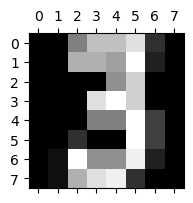

My prediction is 3
sk prediction is 3
Actual number is 3


In [154]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
# Plot the image
plt.figure(figsize=(2, 2))
plt.gray()
plt.matshow(dimage, fignum=1)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, l2, l3, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))


(c) 2024 SW Lee